In [4]:
import numpy as np
from scipy.signal import find_peaks, general_gaussian, fftconvolve
import pandas as pd
import matplotlib.pyplot as plt

# 1. signal detection of time series

In [5]:
## import the time series file
df = pd.read_excel("./../../../Offline/Data_analysis/0426/output/Barelona_data_analysis_26.04_Yufang Hao_data.xlsx")

In [6]:
## Jen's method using differentation to distinguish the "plateau"
x = np.arange(0,len(df),1)
y = df['j15NO2']
## fill data point of NAN with the former one.
y = y.fillna(method='ffill')
deriv = np.diff(y)

[ 39  66  93 119 146 172 199 225 252 279 305 332 358 385 411 438 464 491
 517 544 570 597 623 650 677 703 730 756 763]
[ 55  81 108 134 161 188 214 241 267 292 294 320 347 373 400 427 451 453
 480 506 533 557 559 590 612 639 666 692 719 732 745 772]


(-2.2, 2.2)

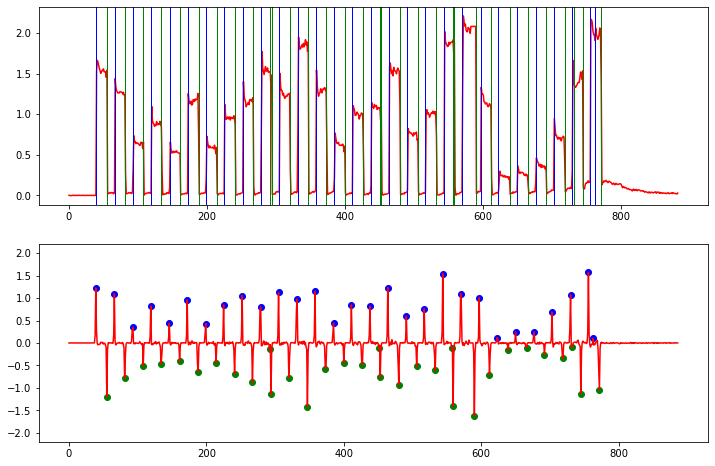

In [7]:
N = 2
window = general_gaussian(2*N+1, p=1.0, sig=0.5)
filtered = fftconvolve(window, deriv)
filtered = (np.average(deriv) / np.average(filtered)) * filtered
filtered = np.roll(filtered, -N)

pos_peaks, pos_details = find_peaks( filtered,height=0.1 )#height=20, distance=1
neg_peaks, neg_details = find_peaks(-filtered,height=0.1)# height=20, distance=1

print(pos_peaks)
print(neg_peaks)


fig = plt.figure(figsize = (12,8))
ax1 = plt.subplot(211)
plt.plot(x,y, color = 'r')

for peak in pos_peaks:
    plt.axvline(peak, color='blue',linewidth = 1.0,linestyle = '-')
for peak in neg_peaks:
    plt.axvline(peak, color='green',linewidth = 1.0,linestyle = '-')

ax2 = plt.subplot(212)
plt.plot(filtered, color = 'r')

for peak in pos_peaks:
    plt.scatter(peak,filtered[peak], color='blue')
for peak in neg_peaks:
    plt.scatter(peak,filtered[peak], color='green')
plt.ylim(-2.2,2.2)

In [8]:
def clean_peak(peak_list,peak_details, length):
    ind_ = []
    for i in np.arange(1,len(peak_list),1):
        if (peak_list[i]-peak_list[i-1]) < length:
            if peak_details['peak_heights'][i]>peak_details['peak_heights'][i-1]:
                ind_.append(i-1)
            else:
                ind_.append(i)
    peak_edit = np.delete(peak_list,ind_)
    print (len(peak_edit),len(peak_list))  
    return (peak_edit)

In [9]:
pos_filtered = clean_peak(pos_peaks,pos_details,20) ## 20 was selected as a suitable range between two pos/neg edge.
neg_filtered = clean_peak(neg_peaks,neg_details,20)

28 29
28 32


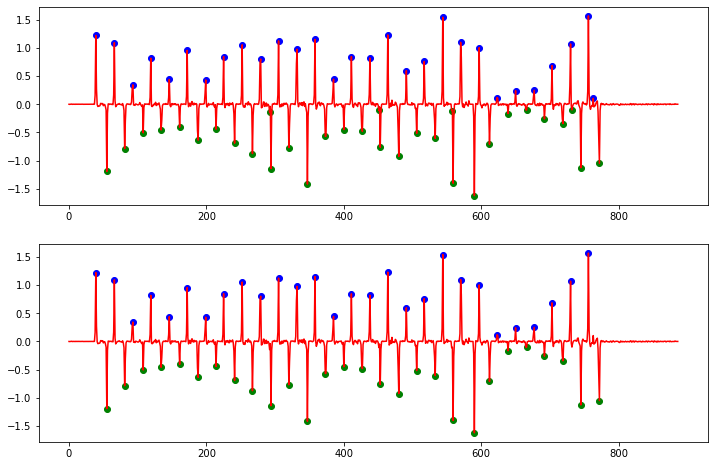

In [10]:
fig = plt.figure(figsize = (12,8))
ax1 = plt.subplot(211)
plt.plot(filtered, color = 'r')

for peak in pos_peaks:
    plt.scatter(peak,filtered[peak], color='blue')
for peak in neg_peaks:
    plt.scatter(peak,filtered[peak], color='green')

ax2 = plt.subplot(212)
plt.plot(filtered, color = 'r')

for peak in pos_filtered:
    plt.scatter(peak,filtered[peak], color='blue')
for peak in neg_filtered:
    plt.scatter(peak,filtered[peak], color='green')
    
# plt.xlim(700,850)  

(600.0, 700.0)

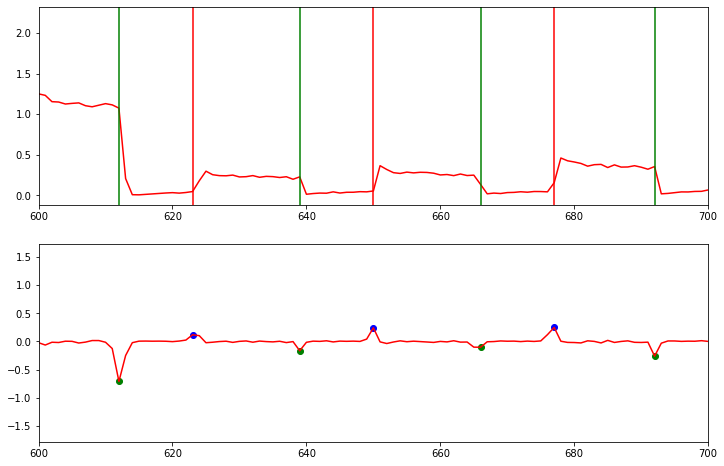

In [11]:
## just for check
a,b = 600,700
fig = plt.figure(figsize = (12,8))
ax1 = plt.subplot(211)
plt.plot(x,y,color = 'r')
for peak in pos_filtered:
    plt.axvline(peak, color='red')
for peak in neg_filtered:
    plt.axvline(peak, color='green')


plt.xlim(a,b)     
ax2 = plt.subplot(212)
plt.plot(filtered, color = 'r')

for peak in pos_filtered:
    plt.scatter(peak,filtered[peak], color='blue')
for peak in neg_filtered:
    plt.scatter(peak,filtered[peak], color='green')
    
plt.xlim(a,b)  

# 2. Import sample information

In [12]:
time_,code_ = [],[]
with open('./../../../Offline/Data_analysis/0426/2021 04 26myFirstRealMeasurment.txt', encoding='utf8') as f:
    for line in f:
        if line.split('\t')[3]!='\n':
            time_.append(line.split('\t')[0])
            code_.append(line.split('\t')[3][:-1])           

In [13]:
dt = pd.DataFrame()
dt['time'] = time_
dt['sample'] = code_
dt = dt.iloc[16:]
print (len(dt))

28


# Output the sample control file

In [14]:
# ATTENTION!!
# We should make sure the first plateau from the Pika output time-series file was the same as the autosampler file

In [17]:
start,end = [],[]
for i in range(0,len(dt),1):
    start.append(pos_filtered[i]+1) #"+1" is to make sure that the first data point not located on the edge.
    end.append(neg_filtered[i]-1) #"+1" is to make sure that the first data point not located on the edge.
dt['start'],dt['end'] = start,end
dt=dt[['sample','start','end']]

In [19]:
dt.head()

,sample,start,end
16,PR_20170104_PM1,40,54
17,PR_20170108_PM1,67,80
18,PR_20170116_PM1,94,107
19,PR_20170120_PM1,120,133
20,PR_20170128_PM1,147,160


In [21]:
dt.to_excel("./template_sample_control_file_26.04.xls",index= False)